In [ ]:
# default_exp laziness

In [ ]:
# from nbdev.showdoc import *
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np

# Region Limited Laziness
The idea: Previous experiments show that the laziness measure reliably distinguishes regions of high and low curvature, but doing so requires extremely large scales of diffusion. This experiment attempts to address this problem, via limiting the number of points diffusion can spread, to localize the effects of laziness within a single region.

In [ ]:
# export
from tqdm.notebook import trange
def local_laziness(A, diffusion_powers = 8, aperture = 80, neighborhood = 1, dynamically_adjusting_neighborhood = False, smoothing=1, verbose=True):
    """Take a localized measure of diffusion laziness, with diffusion restricted to with the given aperture. Estimates curvature.

    Parameters
    ----------
    A : ndarray
        Affinity matrix of data (non-row normalized)
    diffusion_powers : int, optional
        The number of matrix powers to raise the diffusion operature, by default 8
    aperture : int, optional
        The number of nearest neighbors to which to limit the diffusion operator, by default 80
    neighborhood : int, optional
        The number of nearest neighbors of a point to use calculating laziness, by default 1
    dynamically_adjusting_neighborhood : bool, optional
        Whether the aperture and neighborhood should be based on thresholds derived over the dataset (False) or should expand to create the designated number of neighbors everywhere in the dataset (if True), by default False
    smoothing : int, optional
        Number of iterations of diffusion averaging to apply to the laziness values before returning, by default 1
    verbose : bool, optional
        Whether to print debugging statements and return extra debugging information, by default True

    Returns
    -------
    list
        Laziness value at each point
    """
    # First, a proof of concept: iterate through every point,
    # Make a sub-diffusion matrix for that point, consisting only of the nearest neighbors, 
    # And calculate the laziness for each value
    laziness_values = []
    # debugging
    list_of_apertures = []
    list_of_Ps = []
    list_of_Wsubs = []
    for i in trange(A.shape[0]):
        # Get the indices of the "aperture" closest points, as measured by the diffusion probabilities
        idxs = np.argsort(A[i])[-aperture:][::-1]
        # TODO Should these be sorted? Does it matter?
        # Create a sub-diffusion matrix. The pt i should be first.
        W_sub = A[idxs][:,idxs]
        degrees = np.diag(1/np.sum(W_sub,axis=1))
        P = degrees @ W_sub
        # Derive thresholds for the neighborhood partition
        # TODO Could reuse above idxs for greater efficiency
        thresholds = np.partition(P,-neighborhood)[:,-neighborhood]
        P_threshold = np.mean(thresholds) # TODO could also use min
        P_thresholded = (P >= P_threshold).astype(int)
        # Power the matrix
        P_powered = np.linalg.matrix_power(P,diffusion_powers)
        # take the diffusion probs of the neighborhood
        near_neighbors_only = P_powered * P_thresholded
        laziness_aggregate = np.sum(near_neighbors_only,axis=1)
        laziness_of_point = laziness_aggregate[0] 
        laziness_values.append(laziness_of_point)
        list_of_apertures.append(idxs)
        list_of_Ps.append(P_powered)
        list_of_Wsubs.append(W_sub)
    # Smoothing
    if smoothing is not None:  
        D = np.diag(1/np.sum(A,axis=1))
        P = D @ A 
        P_t = np.linalg.matrix_power(P,smoothing)
        ks_smoothed = P_t @ laziness_values
        laziness_values = ks_smoothed.squeeze()
    if verbose:
        return laziness_values, list_of_apertures, list_of_Ps, list_of_Wsubs
    return laziness_values



With the code written, let's test it on our old friend, the torus

In [ ]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.core import DiffusionMatrix
X = torus(n=5000)
A = DiffusionMatrix(X,kernel_type="adaptive",k=20,affinity_matrix_only=True)
P = DiffusionMatrix(X,kernel_type="adaptive",k=20,affinity_matrix_only=False)

Distance to kth neighbors [0.47558308 0.50720098 0.43790677 ... 0.52038092 0.50089104 0.47398191]
Distance to kth neighbors [0.47558308 0.50720098 0.43790677 ... 0.52038092 0.50089104 0.47398191]


In [ ]:
A

array([[5.27064224e+00, 7.82862141e-14, 2.87811528e-25, ...,
        5.37303544e-05, 8.70988853e-12, 1.51408411e-12],
       [7.82862141e-14, 4.94208088e+00, 6.62185519e-02, ...,
        4.60597332e-03, 8.25922033e-01, 3.40375143e-09],
       [2.87811528e-25, 6.62185519e-02, 5.72411400e+00, ...,
        3.89391588e-07, 1.24136330e-03, 1.76513974e-14],
       ...,
       [5.37303544e-05, 4.60597332e-03, 3.89391588e-07, ...,
        4.81691040e+00, 1.72178838e-01, 4.71216871e-10],
       [8.70988853e-12, 8.25922033e-01, 1.24136330e-03, ...,
        1.72178838e-01, 5.00433843e+00, 7.91605940e-13],
       [1.51408411e-12, 3.40375143e-09, 1.76513974e-14, ...,
        4.71216871e-10, 7.91605940e-13, 5.28844718e+00]])

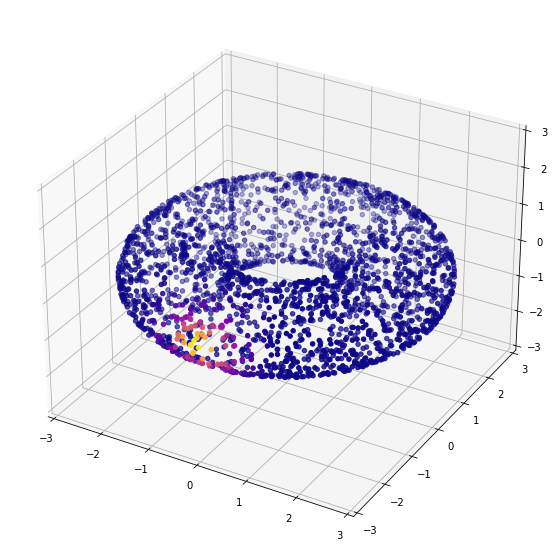

In [ ]:
from diffusion_curvature.core import plot_3d
plot_3d(X,A[0])

## Testing the method

In [ ]:
aperture = 100
diffusion_powers = 16
neighborhood=20
smoothed = 2
ks, apertures, Ps, Ws = local_laziness(A, diffusion_powers=diffusion_powers, aperture=aperture, neighborhood=neighborhood,smoothing=smoothed)

  0%|          | 0/2434 [00:00<?, ?it/s]

Let's see what the aperture looked like

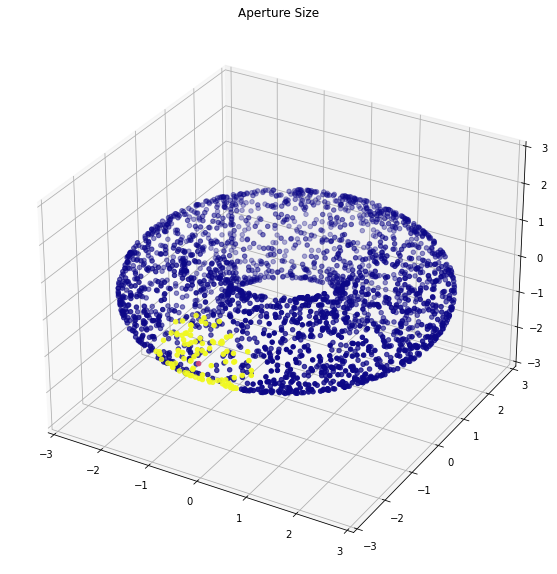

In [ ]:
dist = np.zeros(len(X))
dist[apertures[0]] = 2
dist[0] = 1
plot_3d(X,distribution=dist,title="Aperture Size")


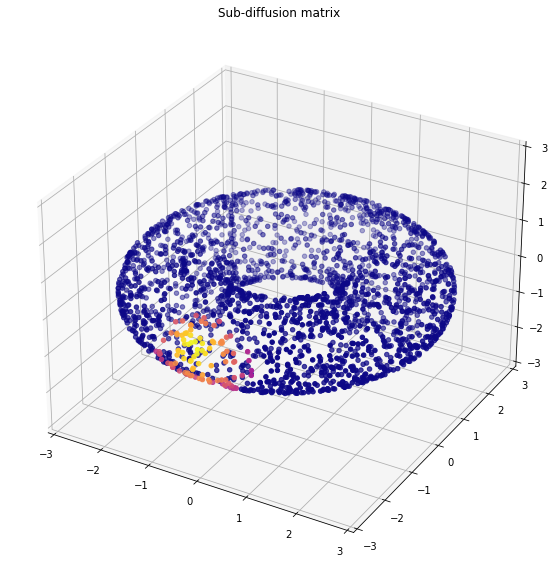

In [ ]:
p = 0
diff_vals = Ps[p][0]
dist = np.zeros(len(X))
for i in range(len(apertures[p])):
    dist[apertures[p][i]] = diff_vals[i]
plot_3d(X,distribution=dist,title="Sub-diffusion matrix")

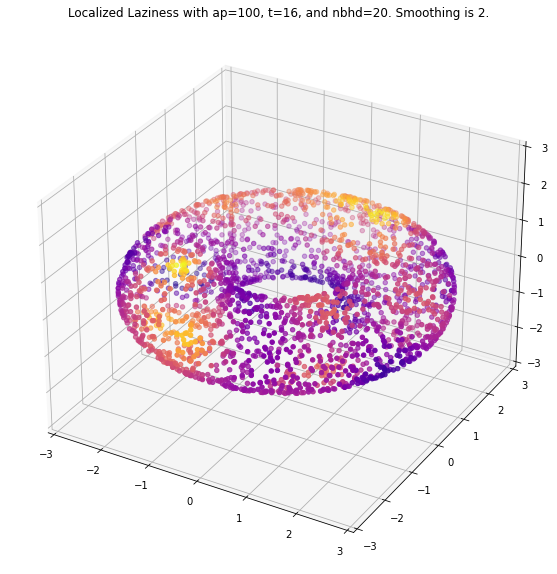

In [ ]:
plot_3d(X,ks,title = f"Localized Laziness with ap={aperture}, t={diffusion_powers}, and nbhd={neighborhood}. Smoothing is {smoothed}.")

# Validation with Distribution Plots

In [ ]:
import matplotlib.pyplot as plt

What are the distributions of laziness values in three parts of the torus?

For a positively curved region, we expect the ass to remain clumped in the middle, hence there should be a smaller number of larger points.

Text(0.5, 1.0, '+ Curvature')

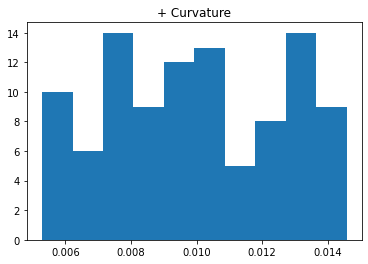

In [ ]:
p = 0
dist = Ps[p][0]
plt.hist(dist)
plt.title("+ Curvature")

For a region of little curvature, we expect a more even spread.

Text(0.5, 1.0, '0 Curvature')

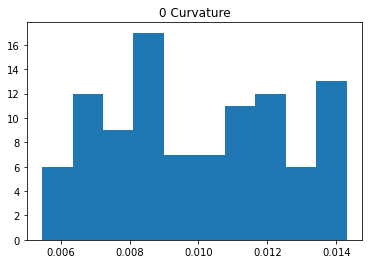

In [ ]:
p = 1
dist = Ps[p][0]
plt.hist(dist)
plt.title("0 Curvature")

For a region of negative curvature, we expect the mass to be pushed to the sides, creating a greater number of not-quite-as-large points.

Text(0.5, 1.0, '- Curvature')

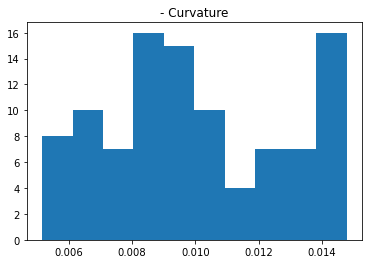

In [ ]:
p = 2
dist = Ps[p][0]
plt.hist(dist)
plt.title("- Curvature")

# Validation with Laziness Decay Graphs

In [ ]:
from diffusion_curvature.laziness import laziness_decay
decaying_lazy = laziness_decay(A, max_steps=40,aperture=100,adaptive_neighborhood=False,use_local_laziness=True, neighborhood=10)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

  0%|          | 0/2434 [00:00<?, ?it/s]

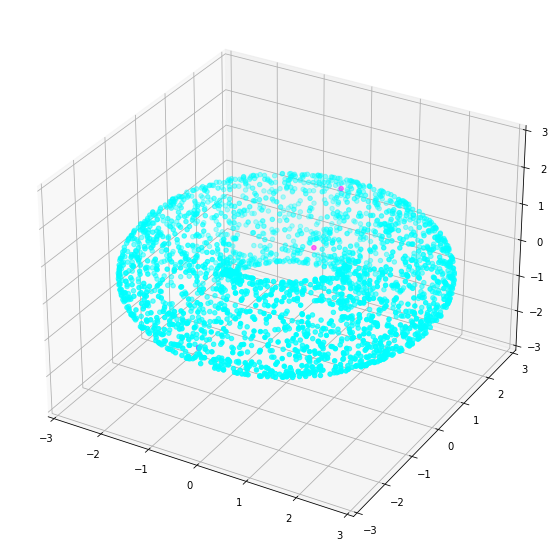

In [ ]:
dist = np.zeros(len(X))
dist[0] = 1
dist[1] = 1
dist[2] = 1
plot_3d(X,dist,cmap="cool")

Text(0, 0.5, 'Laziness')

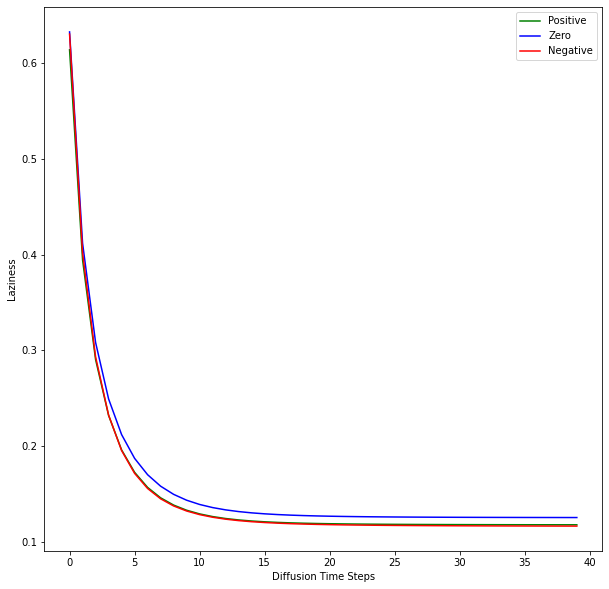

In [ ]:
fig, ax = plt.subplots(1,figsize=(10,10))
ax.plot(decaying_lazy[0],color='green',label='Positive')
ax.plot(decaying_lazy[2],color='blue',label='Zero')
ax.plot(decaying_lazy[1],color='red',label='Negative')
ax.legend()
ax.set_xlabel("Diffusion Time Steps")
ax.set_ylabel("Laziness")

Beautiful! The region-limited laziness value differentiates between negative, positive, and low positive curvature regions after only five iterations of diffusion, after which it stabilizes very quickly.
Compare this to the laziness decay graphs of the traditional laziness measurement, which take upwards of 60 diffusion powers to differentiate the regions.

But note: even on the very first diffusion iteration, the negative and positive regions have been distinguished. Hence, this effect may be due to the same neighborhood-size interference we noted earlier.